In [174]:
%load_ext autoreload
%autoreload 2

from __future__ import division
import numpy as np
import scipy.signal as sg
from scipy.fftpack import rfft, fftfreq
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import matplotlib.colors as colors
from pydub import AudioSegment
import math as m
import tensorflow as tf
import utilities as util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
for i in range(1, 6):
    Note = "B"
    filename = "Trombone_" + Note + "(" + str(i) + ").wav"
    sound = AudioSegment.from_wav("../../" + filename)
    sound = sound.set_channels(1)
    sound.export("../samples/Trombone/" + filename, format="wav")

In [22]:
guitar_note_fs,  guitar_note_wav,  guitar_note_freq,  guitar_note_time,  guitar_note_spec,  guitar_note_argsort,  = util.gather_data('../samples/Guitar_C_Major_Note.wav')


In [16]:
note_freq = util.frequencies('A0', 'D8')
df = np.diff(note_freq)

smallest_nps = 44100/24 * 4/3 
smallest_nps = 2**int(np.log2(smallest_nps))
nps = np.maximum(np.int64(2**np.ceil(np.log2(44100/df))), smallest_nps)
nps_uniq = list(np.unique(nps))
a = 2**(1/12)
lo_factor = 0.5*(1+1/a)
hi_factor = 0.5*(1+a) 
data = []

In [55]:
freq = guitar_note_freq
nf = 50
lo = nf*lo_factor
hi = nf*hi_factor
ind = (freq>=lo)&(freq<=hi)

In [70]:
ind

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [73]:
nps_ind = nps_uniq.index(nps[0])

In [75]:
nps_ind

4

In [81]:
full_spec

[<tf.Tensor 'frame_36/Reshape_4:0' shape=<unknown> dtype=float32>]

In [193]:
def tf_normal_peak(vals, dfreq):
    if vals.shape[0] == 1: return vals

    sums = tf.reduce_sum(vals, 0, keepdims=True)
    
    weights = vals/sums
    print(weights.dtype)
#     freqs = np.arange(1, vals.shape[0]+1)[:,None] # approximation of frequencies (exact values not needed)
    # 
    freqs = tf.range(tf.cast(tf.shape(vals)[0], 'float64'), dtype='float64')

    mean = tf.reduce_sum(weights*freqs[:,None], 0, keepdims=True) # the weighted mean
    
    var = tf.truediv(tf.reduce_sum(((freqs[:,None]-mean)**2)*weights, 0),df)
    
    denom_var = tf.multiply(tf.constant(2.0, dtype='float64'), m.pi)
    
    denom_var_mult = tf.scalar_mul(denom_var, var)
    # Start of nans.. Sometimes slighty < 0...
    # denom = tf.sqrt(denom_var_mult) if (denom_var_mult > 0) else 0
    denom = tf.sqrt(tf.abs(denom_var_mult))
    
    dst_peak = tf.truediv(tf.constant(1.0, dtype='float64'),denom)
    
    peak = dst_peak * df * tf.squeeze(sums) if (dst_peak != 'Nan') else 0
    
    return peak

In [156]:
full_spec = []
for nperseg in nps_uniq:
    print('...')
    signals = tf.placeholder(tf.float32)

    frames = tf.contrib.signal.frame(signals, frame_length=np.int32(nperseg),
                                     frame_step=np.int32(nperseg-smallest_nps))


    stfts = tf.contrib.signal.stft(signals, frame_length=np.int32(nperseg),
                                   frame_step=np.int32(nperseg-smallest_nps),
                                   fft_length=np.int32(nperseg))

    power_spectrograms = tf.real(stfts * tf.conj(stfts))

    magnitude_spectrograms = tf.abs(stfts)
    full_spec.append(magnitude_spectrograms)

...
...
...
...
...


In [160]:
with tf.Session() as sess:
    mag_spects = sess.run(magnitude_spectrograms, feed_dict={signals:guitar_note_wav})
    pow_spects = sess.run(power_spectrograms, feed_dict={signals:guitar_note_wav})

 ...]

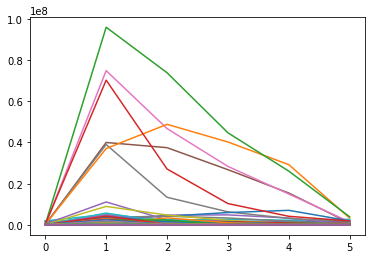

In [163]:
plt.plot(mag_spects)

In [162]:
pow_spects

array([[6.6230144e+07, 1.5793857e+07, 6.8643719e+04, ..., 9.1541675e+02,
        1.6215985e+03, 1.1928287e+03],
       [8.2189064e+07, 2.5118992e+07, 7.4613362e+05, ..., 1.3404159e+03,
        7.2787598e+02, 3.7592059e+02],
       [8.0421240e+07, 2.5908948e+07, 1.4229710e+07, ..., 2.9955867e+03,
        1.8483402e+03, 1.2894667e+02],
       [6.0673664e+07, 1.5606056e+07, 4.6812949e+04, ..., 2.5098242e+03,
        6.4388350e+03, 5.9956592e+03],
       [6.6065876e+07, 1.6134390e+07, 3.3823812e+04, ..., 3.7767947e+02,
        7.3856781e+02, 1.7026907e+03],
       [7.1760856e+07, 1.9464508e+07, 7.6626138e+05, ..., 9.5238269e+02,
        2.9695255e+02, 4.7742676e+02]], dtype=float32)

In [177]:
nps_uniq, dfreqs, notes = util.precompute_spect()

In [182]:
tf_spec[:,slc].shape

TensorShape(None)

In [186]:
tf.shape(tf_spec[:,slc])[0]

<tf.Tensor 'strided_slice_34:0' shape=() dtype=int32>

In [159]:
tf.shape(magnitude_spectrograms)

<tf.Tensor 'Shape:0' shape=(?,) dtype=int32>

In [194]:
full_spec = []
for nperseg in nps_uniq:
    print('...')
    signals = tf.placeholder(tf.float32)

    frames = tf.contrib.signal.frame(signals, frame_length=np.int32(nperseg),
                                     frame_step=np.int32(nperseg-smallest_nps))


    stfts = tf.contrib.signal.stft(signals, frame_length=np.int32(nperseg),
                                   frame_step=np.int32(nperseg-smallest_nps),
                                   fft_length=np.int32(nperseg))

    power_spectrograms = tf.real(stfts * tf.conj(stfts))

    magnitude_spectrograms = tf.abs(stfts)
    full_spec.append(magnitude_spectrograms)

for nps_ind, slc in notes:
    tf_spec = full_spec[nps_ind]
    tf_np = tf_normal_peak(tf_spec[:,slc], dfreqs[nps_ind])


...
...
...
...
...
<dtype: 'float32'>


TypeError: Input 'y' of 'Mul' Op has type float64 that does not match type float32 of argument 'x'.

In [120]:
tf_spec = full_spec[0]

In [121]:
tf_spec[:,None]

<tf.Tensor 'strided_slice_3:0' shape=<unknown> dtype=float32>

In [123]:
len(nps_uniq)

5

In [125]:
len(full_spec)

5

In [126]:
len(note_freq)

89

In [110]:
with tf.Session() as sess:
    spects = sess.run(magnitude_spectrograms, feed_dict={signals:guitar_note_wav})

In [40]:
f, t, sp = sg.spectrogram(guitar_note_wav, 44100, nperseg=nps_uniq[0], noverlap=nps_uniq[0]-smallest_nps)

In [166]:
print('FS', guitar_note_fs)
print('WAV', guitar_note_wav.shape)
print('Corrections', guitar_note_freq.shape)
print('TIME', guitar_note_time.shape)
print('F', f.shape)
print('T', t.shape)
print('SP', sp.shape)
print('TF SPEC', mag_spects.shape)

FS 44100
WAV (196475,)
Corrections (88,)
TIME (95,)
F (1025,)
T (95,)
SP (1025, 95)
TF SPEC (6, 16385)
